In [2]:
import random
# import mlflow
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import inspect 
import sys
import os
import time
import json
import copy
import re
import warnings
from pprint import pprint
import torch
# import tensorflow as tf
import scipy.signal as sn
from types import SimpleNamespace

%load_ext autoreload
%autoreload 2
%matplotlib inline
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (20, 6)
# pd.reset_option('vdisplay.')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
from easydict import EasyDict as edict

ModuleNotFoundError: No module named 'easydict'

In [65]:
import argparse

# from cfg_lstm import *
from utils import *


def parse_args():
    parser = argparse.ArgumentParser(description="TSMixer for Time Series Forecasting")
    parser.add_argument("--seed", type=int, default=0, help="random seed")
    parser.add_argument(
        "--data_dir", type=str, default="./data/tsf_datasets", help="set data directory"
    )
    parser.add_argument("--data_type", type=str, default="elec", help="set data folder")

    args = parser.parse_args([])

    return vars(args)


# args
args = parse_args()
pprint(args)

{'data_dir': './data/tsf_datasets', 'data_type': 'elec', 'seed': 0}
<class 'dict'>


In [ ]:
# args = SimpleNamespace(**args_tsmixer)
args = SimpleNamespace(**args_lstm)
pprint(args)


# print(cfg)
# print(hp)
def seed_everything(hash_para, add_hash_num=0):
    if isinstance(hash_para, str):
        seed = hash(hash_para) % 2**32 + add_hash_num
    else:
        seed = hash_para + add_hash_num

    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

    return seed


SEED = seed_everything(args.filename)  # Seed 고정
# load datasets
# args = SimpleNamespace()

In [50]:
from data_provider import *

tsfdataloader = TSFDataLoader(
    args.filename,
    args.batch_size,
    args.seq_len,
    args.pred_len,
    args.feature_type,
    args.target,
    limit=[None, 1500],
    print_option=False,
)


dataloaders = tsfdataloader.get_dataloaders()
df = tsfdataloader.get_df()
# print(y_batch)

dir: ./data/base/electricity.csv
target idx: 2


In [54]:
import models, losses
import torch.optim as optim

pprint(args)
(x_batch, y_batch), n_feature, target_idx = tsfdataloader.get_data_info()
args.n_feature = n_feature
build_model = getattr(models, args.model).build_model
model = build_model(
    args.seq_len,
    args.n_feature,
    args.hidden_dims,
    args.dropout,
    args.n_block,
    args.pred_len,
    target_idx,
    args.options,
)
optimizer = getattr(optim, args.optim_name)(model.parameters(), lr=args.lr)
# print(model)
# print(optimizer)
y_pred = model(x_batch)
print(f"pred: {y_pred.shape} vs true: {y_batch.shape}")

loss_fn = losses.build_loss_fn(args.lossfn_name)
# loss = loss_fn(y_pred, y_batch)
# print(loss)

namespace(filename='electricity',
          seq_len=48,
          pred_len=24,
          batch_size=64,
          feature_type='MS',
          target='3',
          model='tslstm',
          norm_type='B',
          activation='relu',
          dropout=0.05,
          n_block=2,
          hidden_dims=[192],
          output_dims=[128],
          optim_name='Adam',
          lossfn_name='MSE',
          lr=0.001,
          epochs=10,
          options={'bidirectional': False},
          n_feature=321)
x_batch: torch.Size([64, 48, 321])
y_batch: torch.Size([64, 24])
n_feature:321
pred: torch.Size([64, 24]) vs true: torch.Size([64, 24])


In [2]:
import torch.optim as optim
import runners


def prepare_experiment(epochs):
    # * declaration
    build_model = getattr(models, args.model).build_model
    model = build_model(
        args.seq_len,
        args.n_feature,
        args.hidden_dims,
        args.dropout,
        args.n_block,
        args.pred_len,
        target_idx,
        args.options,
    )
    optimizer = getattr(optim, args.optim_name)(model.parameters(), lr=args.lr)

    loss_fn = losses.build_loss_fn(args.lossfn_name)

    run_equipment = dict(
        model=model,
        optimizer=optimizer,
        loss_fn=loss_fn,
        dataloaders=dataloaders,
        seed=SEED,
        seq_len=args.seq_len,
    )

    runner = runners.TSFRunner(run_equipment, epochs=epochs)
    return runner


runner = prepare_experiment(epochs=20)

losses_df = runner.run()

NameError: name 'models' is not defined

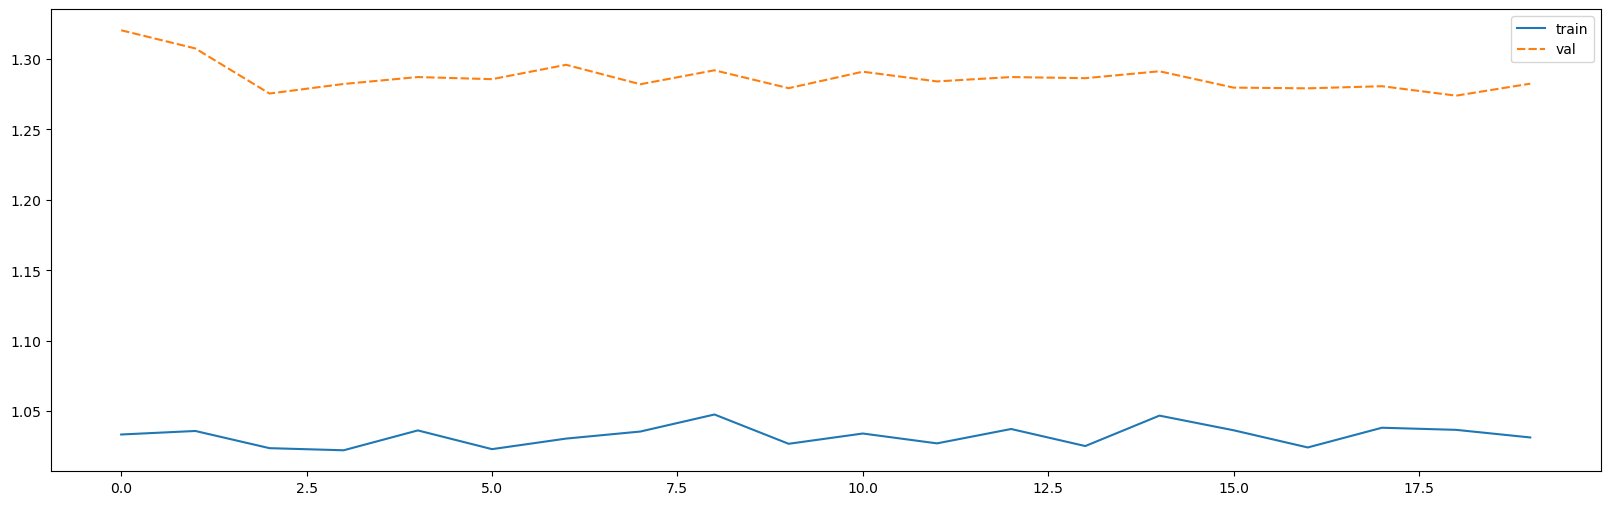

In [ ]:
sns.lineplot(losses_df)
plt.show()